# What is driving customer churn at Telco?


## Imports

In [1]:
# import libraries and modules
import acquire
import prepare
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier



## Acquire


Import data from the telco_churn Database on the Codeup DB Server using a SQL query on 1/2/23

In [2]:
# Acquire data 
df = acquire.get_telco_data()  # Import data using acquire file
print('Rows, Columns ',df.shape,'\n') #View shape of df
print(df.columns) #View column names

Rows, Columns  (7043, 25) 

Index(['customer_id', 'payment_type_id', 'internet_service_type_id',
       'contract_type_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'tenure', 'phone_service', 'multiple_lines', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'paperless_billing', 'monthly_charges',
       'total_charges', 'churn', 'contract_type', 'internet_service_type',
       'payment_type', 'churn_month'],
      dtype='object')


Our df has 7043 rows which each represent a customer. Our columns give us more information on each customer such as how much they pay each month, how much they've paid total, and how many addons they subscribe to above the basic internet subscription.

## Prepare

* List steps taken to clean your data here
* In particular call out how you handle null values and outliers in detail
* You must do this even if you do not do anything or do not encounter any
* Any time there is potential to make changes to the data you must be upfront about the changes you make or do not make

1. Drop following columns: 'Unnamed: 0','payment_type_id', 'internet_service_type_id', 'contract_type_id','customer_id'  
2. Turn 'total_charges' into a float. 
3. Create 'addons' column which sums the values from 'phone_service', 'multiple_lines', 'online_security','online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies'  
4. Create dummy values to use for Machine Learning

There are no null values to deal with

In [3]:
df = prepare.prep_telco(df) # Clean df



Split data into train, validate, and test in order to start exploring the questions

In [4]:
#split data into train, validate, test
train, X_train, y_train, X_val, y_val, X_test, y_test = prepare.split_data(df,'churn') 

## Explore

* Here you will explore your data then highlight 4 questions that you asked of the data and how those questions influenced your analysis
* Remember to split your data before exploring how different variables relate to one another
* Each question should be stated directly 
* Each question should be supported by a visualization
* Each question should be answered in natural language
* Two questions must be supported by a statistical test, but you may choose to support more than two
* See the following example, and read the comments in the next cell

### Do customers with higher monthly_charges churn at a different rate?

In [5]:
# Print out monthly_avg mean and churn rates of customers who pay above and below average per month
monthly_avg = train.monthly_charges.mean()
above_avg = train[train['monthly_charges']>monthly_avg].churn.mean()
below_avg = train[train['monthly_charges']<monthly_avg].churn.mean()
monthly_avg, above_avg, below_avg

(64.91416434187154, 0.34814143245693563, 0.1600460564191134)

The average monthly charges for all customers is $64.81. Customers who pay more than that churn at a rate of 34%. Customers who pay less churn at a rate of 16%

<AxesSubplot:title={'center':'Pay Less'}>

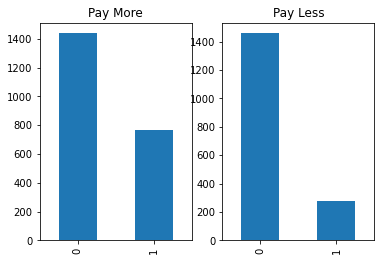

In [6]:
# Create two bar charts
fig, axes = plt.subplots(nrows=1, ncols=2)
train[train['monthly_charges']>monthly_avg].churn.value_counts().plot(ax=axes[0], kind='bar',title='Pay More')
train[train['monthly_charges']<monthly_avg].churn.value_counts().plot(ax=axes[1], kind='bar',title='Pay Less')

There are more than double the amount of people who churn who pay more than average compared to paying less than average

We will run a one-sample T-test to determine whether there is a stastically significant difference between the monthly charges of customers who churn compared to those who don't

Hypothesis:  
H0: Churn is independent of monthly_charges  
Ha: Churn is dependent on monthly_charges

In [7]:
# Run T-Test
alpha = .05  #set alpha level
churn_sample = train[train.churn == 1].monthly_charges  #setup monthly_charges for people who have churned
overall_mean = train.monthly_charges.mean() #overall mean

t, p = stats.ttest_1samp(churn_sample, overall_mean) #one-sample T-test

if p < alpha:
    print(f'There is a statistically significant difference: alpha = .05, p = {round(p,2)}')

There is a statistically significant difference: alpha = .05, p = 0.0


There is indeed a difference in monthly charges between customers who churn and those who don't

### Do customers with a partner or dependents churn at a different rate?

<AxesSubplot:title={'center':'No Dependent or Partner'}>

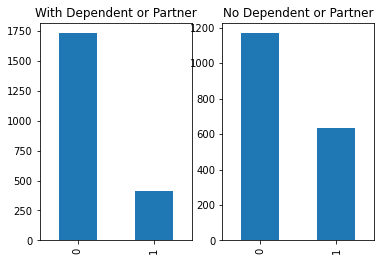

In [8]:
# Create two bar plots
fig, axes = plt.subplots(nrows=1, ncols=2)
train[(train.partner==1) | (train.dependents==1)].churn.value_counts().plot(ax=axes[0], kind='bar',title='With Dependent or Partner')

train[(train.partner==0) & (train.dependents==0)].churn.value_counts().plot(ax=axes[1], kind='bar',title='No Dependent or Partner')

We will run a chi^2 test to see if there is a statistically significant relationship between churn and whether a customer has a dependent or partner

Hypothesis:  
H0: Churn is independent of parner_dep  
Ha: Churn is dependent on parner_dep

In [9]:
# Run chi2 test
alpha = .05
observed = pd.crosstab(train.churn, train.partner_dep)
chi2, p, degf, expected = stats.chi2_contingency(observed)
if p<alpha:
    print('There is a statistically significant relationship')

There is a statistically significant relationship


Customers with no dependent or partner are churning at a higher rate than those without

## What month are customers most likely to churn?

In [10]:
# Value counts of churn
train[train['churn']==1][['churn_month']].value_counts()

churn_month
2022-01-31     1046
dtype: int64

Every customer churned on the exact same date - Jan 31, 2022!

## Do customers with more addons churn at a different rate?

Run a chi square test to check for statistically significant relationship

<AxesSubplot:xlabel='churn', ylabel='count'>

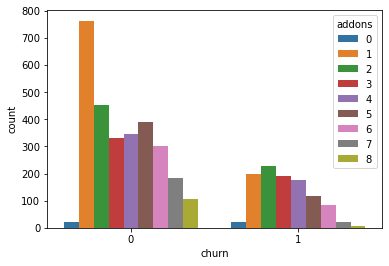

In [11]:
# Create countplot between churn and addons
sns.countplot(data=train,x='churn',hue='addons')

It looks like customers with only 1 addon are more likely to churn.

Hypothesis:  
H0: Churn is independent of addons   
Ha: Churn is dependent on addons

In [12]:
# Set alpha level and run chi2 test
alpha = .05
observed = pd.crosstab(train.churn,train.addons)
chi2, p, degf, expected = stats.chi2_contingency(observed)
if p<alpha:
    print('There is a statistically significant relationship')

There is a statistically significant relationship


Some relationship exists between the number of addons and churn rate.

### 1) Question about the data
* Ask a question about the data for which you got a meaningful result
* There is no connection can be a meaningful result

### 2) Visualization of the data answering the question

* Visualizations should be accompanied by take-aways telling the reader exactly what you want them to get from the chart
* You can include theses as bullet points under the chart
* Use your chart title to provide the main take-away from each visualization
* Each visualization should answer one, and only one, of the explore questions

### 3) Statistical test
* Be sure you are using the correct statistical test for the type of variables you are testing
* Be sure that you are not violating any of the assumptions for the statistical test you are choosing
* Your notebook should run and produce the results of the test you are using (This may be done through imports)
* Include an introduction to the kind of test you are doing
* Include the Ho and Ha for the test
* Include the alpha you are using
* Include the readout of the p-value for the test
* Interpret the results of the test in natural language (I reject the null hypothesis is not sufficient)

### 4) Answer to the question
* Answer the question you posed of the data by referring to the chart and statistical test (if you used one)
* If the question relates to drivers, explain why the feature in question would/wouldn't make a good driver

## Exploration Summary
* After your explore section, before you start modeling, provide a summary of your findings in Explore
* Include a summary of your take-aways
* Include a summary of the features you examined and weather or not you will be going to Modeling with each feature and why
* It is important to note which features will be going into your model so the reader knows what features you are using to model on

## Modeling

### Introduction
* Explain how you will be evaluating your models
* Include the evaluation metric you will be using and why you have chosen it
* Create a baseline and briefly explain how it was calculated 

In [13]:
# If you use code to generate your baseline run the code and generate the output here

Printout should read: <br>
Baseline: "number" "evaluation metric"

### Best 3 Models
* Show the three best model results obtained using your selected features to predict the target variable
* Typically students will show the top models they are able to generate for three different model types

## You may use this as a template for how to introduce your models:

In [14]:
# Remove object dtypes from my dfs
X_train = X_train.select_dtypes(exclude ='object')
X_val = X_val.select_dtypes(exclude ='object')
X_test = X_test.select_dtypes(exclude ='object')

### Model Type

In [39]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=21)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_train)
y_pred_proba = rf.predict_proba(X_train)
print('Accuracy of Random Forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))
print('Accuracy of Random Forest classifier on validate set: {:.2f}'
     .format(rf.score(X_val, y_val)))



Accuracy of Random Forest classifier on training set: 0.77
Accuracy of Random Forest classifier on validate set: 0.77


In [38]:
# LogisticRegression
lr = LogisticRegression(C=1, class_weight={0:1, 1:99}, random_state=21, intercept_scaling=1, solver='lbfgs',max_iter=500)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_train)
y_pred_proba = lr.predict_proba(X_train)
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(lr.score(X_train, y_train)))
print('Accuracy of Logistic Regression classifier on validation set: {:.2f}'
     .format(lr.score(X_val, y_val)))





Accuracy of Logistic Regression classifier on training set: 0.36
Accuracy of Logistic Regression classifier on validation set: 0.36


In [45]:
# K-Nearest Neighbor
knn = KNeighborsClassifier(n_neighbors=15, weights='uniform')
knn.fit(X_train, y_train)

print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of KNN classifier on validate set: {:.2f}'
     .format(knn.score(X_val, y_val)))
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of KNN classifier on training set: 0.80
Accuracy of KNN classifier on validate set: 0.79
Accuracy of KNN classifier on test set: 0.78


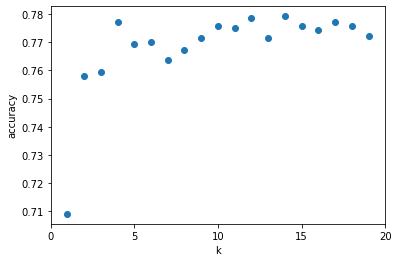

In [41]:
# Plot accuracy levels for different n_neighbors levels
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])
plt.show()

Printout of model code should read: <br>
"Model Type" <br>
"evaluation metric" on train: "evaluation result" <br>
"evaluation metric" on validate: "evaluation result"

### Test Model
* Choose the best model out of the three as you best model and explain why you have chosen it
* Explain that you will now run your final model on test data to gauge how it will perform on unseen data

In [18]:
# Code that runs the best overall model on test data (this may be imported from a module)

Printout of model code should read: <br>
"Model Type" <br>
"evaluation metric" on Test: "evaluation result" <br>

### Modeling Wrap 
* Give a final interpretation of how the models test score compares to the baseline and weather you would recommend this model for production

## Conclusion

### Summery
* Summarize your findings and answer the questions you brought up in explore 
* Summarize how drivers discovered lead or did not lead to a successful model 

### Recommendations
* Recommendations are actions the stakeholder should take based on your insights

### Next Steps
* Next Steps are what you, as a Data Scientist, would do if provided more time to work on the project

**Where there is code in your report there should also be code comments telling the reader what each code block is doing. This is true for any and all code blocks even if you are using a function to import code from a module.**
<br>
<br>
**Your Notebook should contain adequate markdown that documents your thought process, decision making, and navigation through the pipeline. As a Data Scientist, your job does not end with making data discoveries. It includes effectively communicating those discoveries as well. This means documentation is a critical part of your job.**